# Why Chatbot
* 앱을 새로 깔 필요가 없음
* 앱을 깔필요가 없으니 배울 것도 없음
* 편한 UX - 그냥 텍스트 치면됨
* 즉각적인 Feedback

## Seq2Seq를 활용한 간단한 Q/A 봇을 만들어보자
![이미지](http://suriyadeepan.github.io/img/seq2seq/seq2seq2.png)
* Python 3.5, Tensorflow 1.1, Konlpy (Mecab),Word2Vec (Gensim), matplotlib (Graph)

In [1]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import numpy as np
import sys 

print (sys.version)
print (tf.__version__) #1.1이상 가능 

3.5.2 |Anaconda 4.2.0 (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
1.2.1


### seq2seq를 위한 Data 구성
* 질의 응답별로 LIST로 구성
* operator사용 value값 기준 정렬

In [2]:
# 질문에 따른 답변 정의
train_data = [
                ['안녕', '만나서 반가워'],
                ['넌누구니', '나는 AI 봇이란다.'],
                ['피자 주문 할께', '페파로니 주문해줘'],
                ['음료는 멀로', '콜라로 해줘']
            ]

from konlpy.tag import Mecab
mecab = Mecab('/usr/local/lib/mecab/dic/mecab-ko-dic')
train_data2 = list(map(lambda x : mecab.morphs(' '.join(x))  , train_data))
print(train_data2)
import itertools
char_array = list(itertools.chain.from_iterable(train_data2))
    
char_array = ['P', '[', ']'] + list(set(char_array))  # Padding값을 0으로 주어 weight제외

max_input_text = max(len(s[0]) for s in train_data2)#입력의 차원 수
max_output_text = max(len(s[1]) for s in train_data2)#출력의 차원 수
print (char_array)

train_data2 = []

for qna_data in train_data:
    train_data2 = train_data2 + list(map(lambda x : mecab.morphs(x) , qna_data))
                       
print (train_data2)


max_input_text = 7
max_output_text = 7

[['안녕', '만나', '서', '반가워'], ['넌', '누구', '니', '나', '는', 'AI', '봇', '이', '란다', '.'], ['피자', '주문', '할께', '페파', '로니', '주문', '해', '줘'], ['음료', '는', '멀', '로', '콜라', '로', '해', '줘']]
['P', '[', ']', '는', '주문', '피자', '.', '니', '콜라', '반가워', '해', '넌', '줘', '란다', '이', '할께', '서', '페파', '나', '만나', '봇', '로', '누구', 'AI', '안녕', '멀', '로니', '음료']
[['안녕'], ['만나', '서', '반가워'], ['넌', '누구', '니'], ['나', '는', 'AI', '봇', '이', '란다', '.'], ['피자', '주문', '할께'], ['페파', '로니', '주문', '해', '줘'], ['음료', '는', '멀', '로'], ['콜라', '로', '해', '줘']]


# Vector 구성 (입력된 문장의 글자별 Vector)
 - 일반적으로 처리단위가 작아질수록 미등록어에서 자유롭고 작은 vector 차원을 유지할 수 있지만
 - 문장의 길이가 길어지고, 학습이 어려워지는 문제가 있기에 적절한 embedding을 찾아야하는데 
 - 이부분은 Biz Domain 별 차이가 있음 복잡도나 표현 가능성등을 적절한 균형에서 찾아야함 
 - 아래 소스는 이해하기 쉽도록 글자단위의 Onehot으로 구성

In [3]:
# enumerate 방법 사용 index : value 정렬
num_dic = {n: i for i, n in enumerate(char_array)}

dic_len = len(num_dic)

print ("# Char List : " + str(num_dic))
print ("# Char Size : " + str(dic_len))

# Char List : {'주문': 4, '란다': 13, 'P': 0, '할께': 15, '서': 16, '는': 3, '[': 1, '피자': 5, '.': 6, '나': 18, '만나': 19, '페파': 17, '니': 7, '봇': 20, '로': 21, '콜라': 8, '이': 14, '반가워': 9, ']': 2, '누구': 22, 'AI': 23, '안녕': 24, '음료': 27, '로니': 26, '멀': 25, '해': 10, '넌': 11, '줘': 12}
# Char Size : 28


### One Hot Encodeing
* '안녕??'의 정렬하여 1의 값으로 정렬 <br>
안 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0] <br>
녕 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] <br>
? [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] <br>

In [4]:
def make_train_data(train_data):
    input_batch = []
    output_batch = []
    target_batch = []

    for seq in train_data:
        # 인코더 셀의 입력값. 입력단어의 글자들을 한글자씩 떼어 배열로 만든다.
        seq_0 = mecab.morphs(seq[0]) 
        seq_1 = mecab.morphs(seq[1]) 
        input = [num_dic[n] for n in seq_0 + ['P'] * (max_input_text - len(seq_0)) ]# P는 Padding 값
        # 디코더 셀의 입력값. 시작을 나타내는 [ 심볼을 맨 앞에 붙여준다. (Seq의 구분)
        output = [num_dic[n] for n in (['['] + seq_1 + ['P'] * (max_output_text - len(seq_1)))]
        # 학습을 위해 비교할 디코더 셀의 출력값. 끝나는 것을 알려주기 위해 마지막에 ] 를 붙인다.
        target = [num_dic[n] for n in (seq_1 + ['P'] * (max_output_text - len(seq_1)) + [']'] )]
        input_batch.append(np.eye(dic_len)[input])
        output_batch.append(np.eye(dic_len)[output])
        target_batch.append(target)
    return input_batch, output_batch, target_batch

### 모델 저장을 위한 함수
* 현재폴더의 model폴더를 만들어 모델을 저장한다 
* 모델이 존재할 경우 삭제하고 새로 만든다

In [5]:
file_path = './model'
def model_file(file_path, flag):
    if(flag):
        import os
        saver = tf.train.Saver(tf.global_variables())

        if(not os.path.exists(file_path)):
            os.makedirs(file_path)
        saver.save(sess, ''.join(file_path + "/.model"))
        print("Model Saved")
    else:
        import shutil
        try:
            shutil.rmtree(file_path)
            print("Model Deleted")
        except OSError as e:
            if e.errno == 2:
                # 파일이나 디렉토리가 없음!
                print ('No such file or directory to remove')
                pass
            else:
                raise

### Tensorflow Graph 생성
* seq2seq모델의 Graph 생성
* 동일한 크기의 encoder과 decoder의 크기로 학습

In [6]:
# 옵션 설정
learning_rate = 0.01
n_hidden = 128
total_epoch = 100
# one hot 위한 사이즈
n_class = n_input = dic_len

# 그래프 초기화 
tf.reset_default_graph()
# Seq2Seq 모델은 인코더의 입력과 디코더의 입력의 형식이 같다.
enc_input = tf.placeholder(tf.float32, [None, None, n_input])
dec_input = tf.placeholder(tf.float32, [None, None, n_input])
targets = tf.placeholder(tf.int64, [None, None])

# 인코더
with tf.variable_scope("encoder"):
    enc_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden)
    enc_cell = tf.contrib.rnn.DropoutWrapper(enc_cell, output_keep_prob=0.5)
    outputs, enc_states = tf.nn.dynamic_rnn(enc_cell, enc_input,
                                            dtype=tf.float32)

# 디코더
with tf.variable_scope("decoder"):
    dec_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden)
    dec_cell = tf.contrib.rnn.DropoutWrapper(dec_cell, output_keep_prob=0.5)
    outputs, dec_states = tf.nn.dynamic_rnn(dec_cell, dec_input,
                                            initial_state=enc_states,
                                            dtype=tf.float32)

model = tf.layers.dense(outputs, n_class, activation=None)

#onehot로 sparse사용 
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model, labels=targets)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
input_batch, output_batch, target_batch = make_train_data(train_data)



### 학습결과 출력
* matplotlib 활용 학습 결과 출력

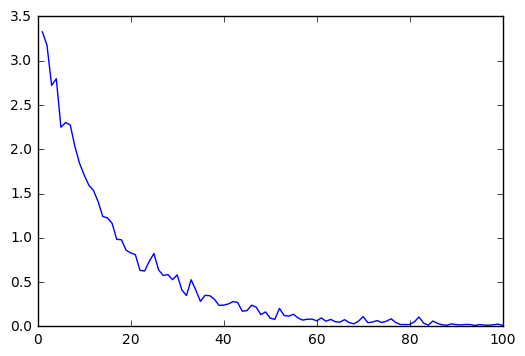

In [7]:
import matplotlib.pyplot as plt

def display_train():
    plot_X = []
    plot_Y = []
    for epoch in range(total_epoch):
        _, loss = sess.run([optimizer, cost],
                           feed_dict={enc_input: input_batch,
                                      dec_input: output_batch,
                                      targets: target_batch})
        plot_X.append(epoch + 1)
        plot_Y.append(loss)
    # Graphic display
    plt.plot(plot_X, plot_Y, label='cost')
    plt.show()

display_train()

### 예측 수행

In [9]:
# 최적화가 끝난 뒤, 변수를 저장합니다.
model_file(file_path, True)

# 단어를 입력받아 번역 단어를 예측하고 디코딩하는 함수
def predict(word):
    input_batch, output_batch, target_batch = make_train_data([word])
    # 결과가 [batch size, time step, input] 으로 나오기 때문에,
    # 2번째 차원인 input 차원을 argmax 로 취해 가장 확률이 높은 글자를 예측 값으로 만든다.
    # http://pythonkim.tistory.com/73
    prediction = tf.argmax(model, 2)
    result = sess.run(prediction,
                      feed_dict={enc_input: input_batch,
                                 dec_input: output_batch,
                                 targets: target_batch})
    # 결과 값인 숫자의 인덱스에 해당하는 글자를 가져와 글자 배열을 만든다.
    decoded = [char_array[i] for i in result[0]]
        
    if 'P' in decoded:
        end = decoded.index('P')
        decoded = decoded[:end]
    elif ']' in decoded:
        end = decoded.index(']')
        decoded = decoded[:end] 
    return decoded




print ("Q: 넌누구니")
print("A: " + ' '.join(predict(['넌누구니',''])))
print ("Q: 피자 주문 할께")
print("A: " + ' '.join(predict(['피자 주문 할께',''])))
print ("Q: 음료는 멀로")
print("A: " + ' '.join(predict(['음료는 멀로',''])))

model_file(file_path, False)

Model Saved
Q: 넌누구니
A: 나 는 AI 봇 이 란다
Q: 피자 주문 할께
A: 페파 로니 주문 해 줘
Q: 음료는 멀로
A: 콜라 로 해 줘
Model Deleted
